In [30]:
import sys
sys.path.append('/Users/nayeongkim/Desktop/HKweather/')
print(sys.path)

['/Users/nayeongkim/miniconda3/envs/HKweather/lib/python313.zip', '/Users/nayeongkim/miniconda3/envs/HKweather/lib/python3.13', '/Users/nayeongkim/miniconda3/envs/HKweather/lib/python3.13/lib-dynload', '', '/Users/nayeongkim/miniconda3/envs/HKweather/lib/python3.13/site-packages', '/Users/nayeongkim/Desktop/HKweather/', '/Users/nayeongkim/Desktop/HKweather/']


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from functions.seasonal import STL, FourierDecomposition, MultiSeasonalDecomposition
import plotly.express as px

In [32]:
treated_data_rep = r'../0_Data/wrangled/' 
HKDaily_AGG = pd.read_pickle(treated_data_rep+"HKDaily_AGG.pkl")
HKDaily_AGG

,TX,RR,UM
Date,,,
1884-01-01,15.3,NaN,NaN
1884-01-02,17.1,NaN,NaN
1884-01-03,19.6,NaN,NaN
1884-01-04,23.2,NaN,NaN
1884-01-05,19.4,NaN,NaN
...,...,...,...
2025-02-24,18.825,0.0,70.909091
2025-02-25,19.069444,0.02381,74.136364
2025-02-26,20.491667,0.681818,82.363636


In [33]:
HKDaily_AGG_for_acf = HKDaily_AGG[['TX']]

# Decomposition of HK weather series

In this section, we will decompose the time series of Temperature, Humidity and Rainfall series of two cities in different components. As it is well known, any kind of time series can be decomposed into four terms:

- **Trend**: A trend is a long-term movement of the series. It is a smooth and steady movement of a time series in a particular direction (increasing or decreasing).  
- **Seasonal**: A seasonal term is the regular variation in relation to the seasonal period. 
- **Cyclical**: It is also a regular variation as the seasonal term, but its regularity is not totally explained by the season, and the period of regularity is not always fixed (Economic recession can come by 10 to 15 years, and its due can differ from time to time) Plus, in terms of its signification, it is more about economical cycles or other cyclical movement than the natural season.
- **Random value (error term)**: The remaining value after removing the trend, seasonal termm cyclical term is seen as a random value. We call it 'error term' or 'noise' too. It represents the inexplained part of our time series.

The final time series is a mixture of these four elements. It can be a combination by different ways, but most commonly observed and used is by sum (additive relation) or by multiplication (multiplicative relation). 

## (1) Autocorrelation plot

To analyze the different components of a time series, before putting it into a decomposition algorithme such as STL (LOESS), it is good to see how the autocorrelation and the partial autocorrelation of the original series look like. Some caracteristics in the autocorrelation and in the partial autocorrelation can reveal the trend and the seasonal/cyclical behaviour.

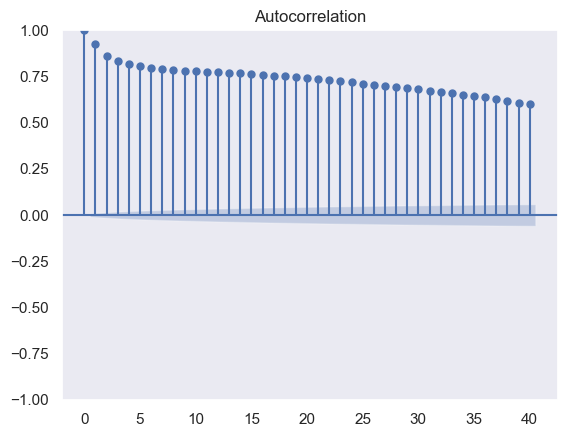

In [34]:
sm.graphics.tsa.plot_acf(HKDaily_AGG_for_acf.squeeze(), lags=40)
plt.show()

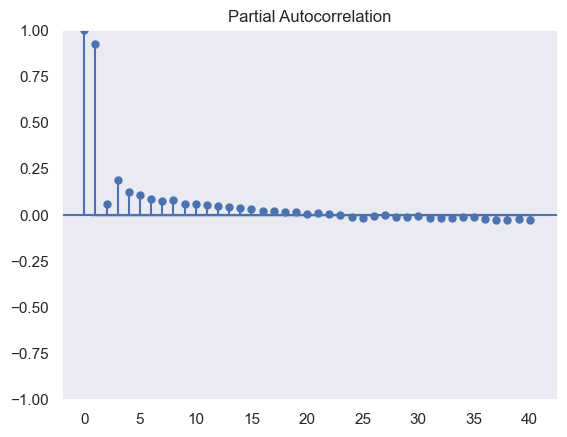

In [35]:
sm.graphics.tsa.plot_pacf(HKDaily_AGG_for_acf.squeeze(), lags=40, method="ywm")
plt.show()

While the autocorrelation plot makes us presume an existence of a trend term in the series, and the autocorrelation plot helps us to have an AR term of (p = t-1) in a classic time series models, these graphs show that the daily frenquency series is too frequent to show the year-round seasonal pattern that we have already noticed in the "0_Solely HK weather data preview" part. So here, it will be relevent to pass to the monthly level by averaging the series by month.

In [36]:
HKDaily_AGG.reset_index(inplace = True)

In [37]:
# Day of the year
HKDaily_AGG['day_of_year'] = HKDaily_AGG['Date'].dt.dayofyear

# Add mean values :
mean_temp = HKDaily_AGG[['Date', 'TX']].groupby('Date').mean().reset_index()
mean_temp['year'] = mean_temp['Date'].dt.year
mean_temp['day_of_year'] = mean_temp['Date'].dt.dayofyear
mean_temp['month'] = mean_temp['Date'].dt.month
mean_temp_monthly = mean_temp[["year","month","TX"]].groupby(["year","month"]).mean()

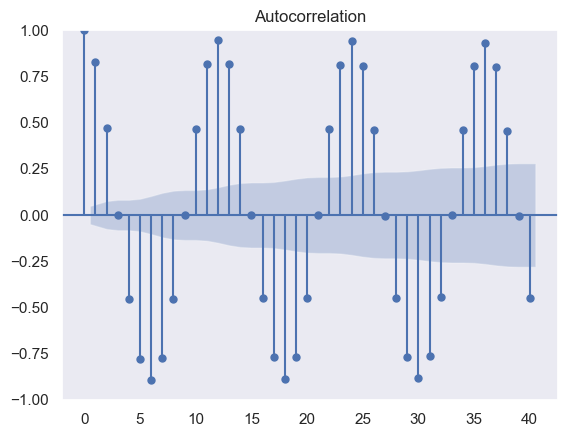

In [38]:
sm.graphics.tsa.plot_acf(mean_temp_monthly.squeeze(), lags=40)
plt.show()

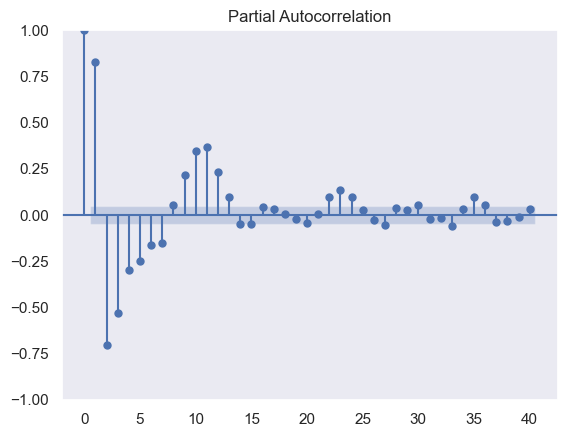

In [39]:
sm.graphics.tsa.plot_pacf(mean_temp_monthly.squeeze(), lags=40, method="ywm")
plt.show()

And yes, the autocorrelation and the partial autocorrelation are effectively demonstrating the non-stationaritity of the Temperature series and the annual structure in the temperature series. The seasonal regularity and the structural movement don't seem to show a longer-term cyclical repurcussion from these graphs. So the key component to forecast the temperature will be the seasonal fluctuation along the year.


## (2) Detrending

Two popular ways to detrend a time series:
- **Moving Average**
- **LOcally Estimated Scatterplot Smoothing (LOESS) regression**, also known as *locally weighted polynomial regression* - non-parametric method which fits a smooth curve onto a noisy signal.

## (3) Deseasonalizing

Two most popular ways to deseason a time series:
- **Period-adjusted averages**: we can adjust the seasonality using the period-adjusted averages. We first calculate the period average for each period. At the end of the exercise, we have as many average values as the number of periods. Then we can also calculate an average of the period averages. Now, we can make these period averages into an index by either subtracting the average of all period averages from each of the period averages (for **additive**) or dividing the average of all period averages from each of the period averages (**multiplicative**).
- Fourier series: In the late 1700s, Joseph Fourier, a mathematician and physicist, while studying heat flow, realized something profound—any periodic function can be broken down into a simple series of sine and cosine waves. It is this property that we use to extract seasonality from a time series because seasonality is a periodic function, and any periodic function can be approximated by a combination of sine and cosine waves.

In [40]:
mean_temp_monthly.reset_index(inplace = True)

In [41]:
date_c = mean_temp_monthly[['year', 'month']]
date_c['day'] = 1
date_index = pd.to_datetime(date_c)

In [42]:
mean_temp_monthly.index = date_index
del mean_temp_monthly['year']
del mean_temp_monthly['month']

- Decomposition with **Moving Average method**:

The moving average decomposition of the seasonal term and the trend with the additive and multiplicative methods are following. When we decompose a time series with moving average method, first we compute the trend term by moving average of the period cycle (12 monthly points to detect a year cycle of the monthly data), and we get the seasonal term averaging by month the series subtracted (or devided for the multiplicative method) the trend term. 

We see that, in below two graphs, that the trend term is not enough smooth, and it is still containing too much noise.

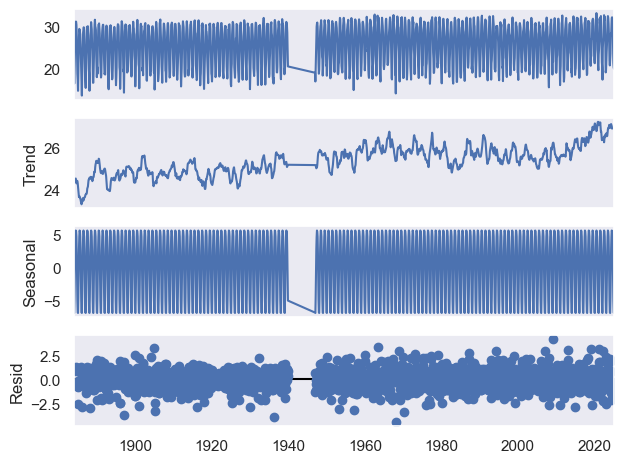

In [43]:
#Does not support misssing values, so using imputed ts instead
res_additive = seasonal_decompose(mean_temp_monthly[['TX']],
                         model="additive", 
                         period = 12)
res_additive.plot()
plt.show()

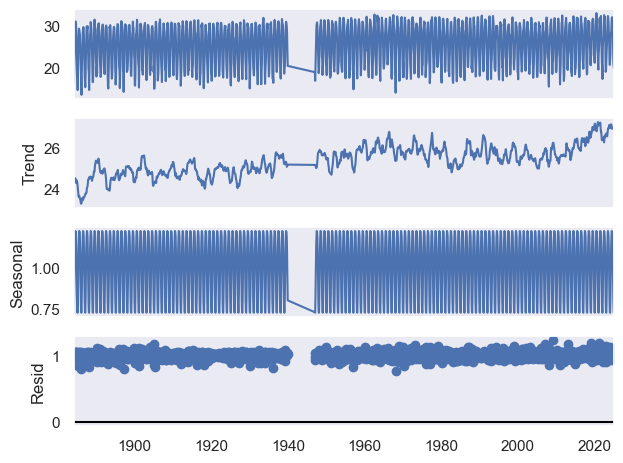

In [44]:
#Does not support misssing values, so using imputed ts instead
res_multiplicative = seasonal_decompose(mean_temp_monthly[['TX']],
                         model="multiplicative", 
                         period = 12)
res_multiplicative.plot()
plt.show()

- Decomposition with STL (LOESS smoothing)

The decomposition using STL method applies a similar procedure with the moving average method. It just uses LOESS non-parametric smoothing instead of the periodic moving average. So, at the first step, the algorithm will seperate the trend term using LOESS smoothing over the original time series. And then, over the time series subtracted to the trend term, the algorithm will compute another LOESS smoothing by each month, which will generate the monthly smoothed terms of detrended series. The final random noise term is obtained by subtracting the original series to the trend term and to the monthly smoothed terms (seasonal terms). 

This STL decomposition method is sometimes more efficient than the moving average decomposition methods. However, with our time series of the Hong Kong monthly temperature data, still the STL decomposition doesn't extract enough well the trend term. It is still too much fluctuated.

In [45]:
from functions.seasonal import STL, FourierDecomposition, MultiSeasonalDecomposition
stl = STL(seasonality_period="month", model = "additive")
res_stl = stl.fit(mean_temp_monthly[['TX']].squeeze(), seasonality=mean_temp_monthly.index.month)
res_stl.plot()


With STL decomposition, I have the option of setting multiple seasonal periods. I tested by half-year and year periods. It doesn't seem to improve the overfitted trend. 

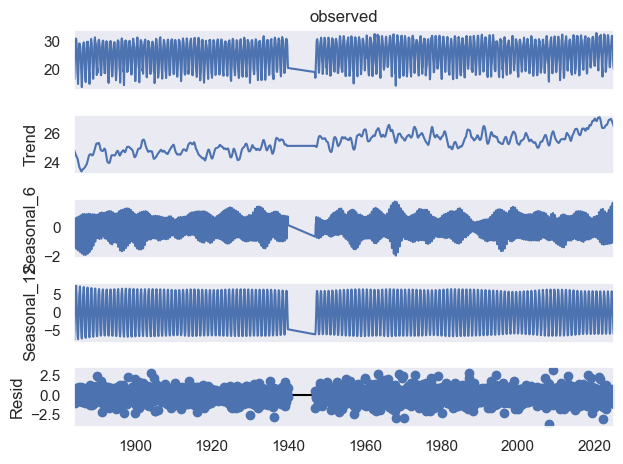

In [46]:
from statsmodels.tsa.seasonal import MSTL
res = MSTL(mean_temp_monthly[['TX']],periods = (6,12)).fit()
res.plot()
plt.show()

- Fourier Decomposition

How about the Fourier decomposition method? This method works with the trigonometric fuctions. It allows to mimic the time series movement by different parametric compositions of Sin and Cosin periodic functions. 

Using this method, we first decompose the trend term using LOESS smoothing (same as for the STL method), and regress the detrended series by Fourier terms, so that the fourier terms are the explainable regressors of the detrended series. There will be remaining noises which become naturally the final noise term.

Using this method, the trend looks much more smooth and well seperated from the noise and the seasonal fluctuations. 

In [47]:
mean_temp_monthly.index.month

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2],
      dtype='int32', length=1610)

In [48]:
#Doesn't support missing values, and expects a series or datafeame with datetime index
fourier_decomp = FourierDecomposition(seasonality_period="month", model = "additive", n_fourier_terms=2)
res_fourier = fourier_decomp.fit(pd.Series(mean_temp_monthly[['TX']].squeeze()), seasonality=mean_temp_monthly.index.month)
res_fourier.plot()

How do the seasonal terms deducted by this Fourier method look like? Are they matching to the yearly seasonal movement that we have noticed in the first part of data visualization (0_Solely HK weather data preview?)

For example, we remember this graph:

[Text(0.5, 0, 'Month of the year'), Text(0, 0.5, 'Temperature (C)')]

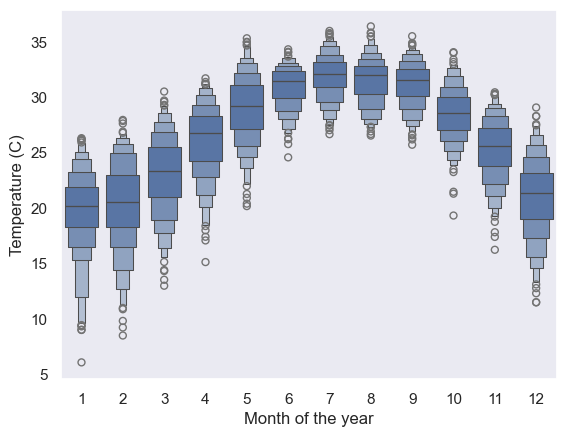

In [49]:
treated_data_rep = r'../0_Data/wrangled/' 
mean_temp = pd.read_pickle(treated_data_rep+"mean_temp.pkl")
mean_temp['month'] = mean_temp['Date'].dt.month
sns.set_theme(style="dark")
g = sns.boxenplot(
    mean_temp, x="month", y="value",
    color="b", width_method="linear",
)
g.set(xlabel = "Month of the year", ylabel ="Temperature (C)")

How this monthly distribution of the temperature is represented in the seasonal terms obtained by our Fourier decomposition?

In [50]:
res_stl_seasonal = res_stl.seasonal

In [51]:
res_stl_df = pd.DataFrame({'month':res_stl_seasonal.index.month,
              'value':res_stl_seasonal})

In [52]:
res_stl_df = res_stl_df.groupby('month').mean()

In [53]:
monthly_profile = mean_temp[['month', 'value']].groupby('month').mean()
monthly_profile['fourier']=np.unique(res_fourier.seasonal)
monthly_profile['ma_additive']=np.unique(res_additive.seasonal)
monthly_profile['ma_multiplicative']=np.unique(res_multiplicative.seasonal)
monthly_profile['stl']=res_stl_df['value'].values
monthly_profile.columns = ['Monthly average', 'Seasonal terms - Fourier',  'Seasonal terms - MA add',  'Seasonal terms - MA Multi',
                            'Seasonal terms - STL']
monthly_profile.reset_index(inplace=True)
monthly_profile = monthly_profile.melt(id_vars = "month")

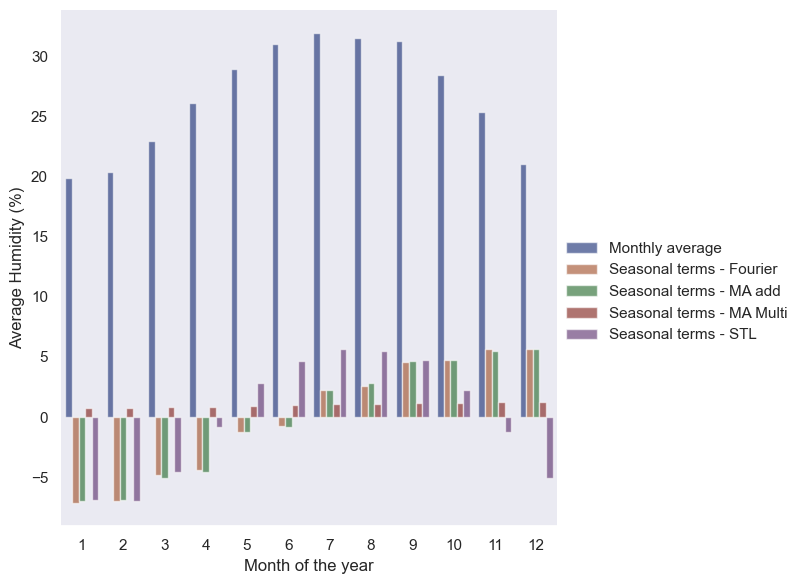

In [54]:
sns.set_theme(style="dark")
g = sns.catplot(
    data=monthly_profile, kind="bar",
    x="month", y="value", hue="variable",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Month of the year", "Average Humidity (%)")
g.legend.set_title("")

When we compare the seasonal terms obtained by 4 different methods, it seems that the one obtained by STL decomposition mimics more relevantly the real seasonal movement of the original series. 

Therefore, it can be interesting to build models onto the detrended daily temperature series - because I'd like to have a daily forecast of the temperature *in fine*. And to use the variable *Month of the year* as one of regressor in our model, to integrate this seasonal effect.